In [1]:
import numpy as np

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import oyster

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Electrode locations for patient TB, from MATLAB script
x_elec_loc = np.array([-6825.092215, -6332.563035, -5840.033855, -5347.504675,
                       -6194.683612, -5702.154432, -5209.625252, -4717.096072,
                       -5564.275010, -5071.745829, -4579.216649, -4086.687469,
                       -4933.866407, -4441.337226, -3948.808046, -3456.278866])
y_elec_loc = np.array([-655.666769, -25.258166, 605.150437, 1235.559040,
                       -1148.195949, -517.787346, 112.621257, 743.029860,
                       -1640.725129, -1010.316526, -379.907924, 250.500679,
                       -2133.254310, -1502.845707, -872.437104, -242.028501])

# MATLAB had the OD at (0,0), we have it at (15,2)
x_elec_loc += e2cm.deg2micron(15)
y_elec_loc += e2cm.deg2micron(2)

r_arr = np.array([260, 520, 260, 520]) / 2.0
r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
h_arr = np.ones(16)*100

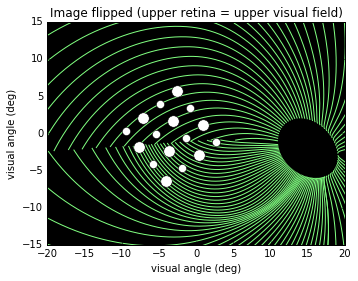

In [3]:
r_rot = 4
axon_x, axon_y = oyster.jansonius(100, 801, rot=r_rot/180*np.pi)
axon_x = np.array(axon_x)
axon_y = np.array(axon_y)
fig, ax = plt.subplots(1)
ax.set_axis_bgcolor('black')

ax.plot(axon_x, -axon_y, c=(0.5, 1, 0.5))
for x, y, r in zip(x_elec_loc, y_elec_loc, r_arr):
    ax.plot(e2cm.micron2deg(x), -e2cm.micron2deg(y), 'ow', markersize=np.sqrt(r/2))
# ax.plot(e2cm.micron2deg(x_elec_loc), -e2cm.micron2deg(y_elec_loc), 'ow', markersize=10)
# ax.plot(e2cm.micron2deg(x_elec_loc[4]), e2cm.micron2deg(y_elec_loc[4]), 'ob', markersize=2)
ax.set_aspect('equal')
ax.set_xlim(-20, 20)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-15, 15)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')
fig.savefig('jansonius_argusI.eps')

In [4]:
# find x,y limits from electrode location
round_to_nearest = 3000.0
x_min = np.floor((x_elec_loc.min() - 500.0) / round_to_nearest) * round_to_nearest
x_max = np.ceil((x_elec_loc.max() + 500.0) / round_to_nearest) * round_to_nearest
y_min = np.floor((y_elec_loc.min() - 500.0) / round_to_nearest) * round_to_nearest
y_max = np.ceil((y_elec_loc.max() + 500.0) / round_to_nearest) * round_to_nearest

axon_lambda = 8
r_sampling = 100  # spatial sampling of the retina
r_file = '../retina_argusI_s%d_l%.0f_rot%.1f_%dx%d.npz' % (r_sampling, axon_lambda, r_rot, x_max - x_min, y_max - y_min)
retina = e2cm.Retina(axon_map=r_file, sampling=r_sampling, axon_lambda=axon_lambda,
                xlo=x_min, xhi=x_max, ylo=y_min, yhi=y_max, rot=r_rot/180*np.pi)

In [5]:
e_all = e2cm.ElectrodeArray(r_arr.tolist(), x_elec_loc, y_elec_loc, h_arr.tolist())
ecs, cs  = retina.electrode_ecs(e_all, integrationtype='dotproduct', normalizationtype='maxcs')

In [6]:
idx_E1 = 0
idx_E2 = 4
tsample = 0.01/1000

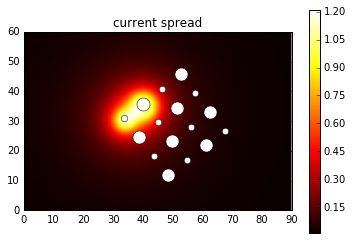

In [7]:
plt.imshow(np.flipud(cs[..., [idx_E1, idx_E2]].sum(axis=2)), cmap='hot')

# also plot the center points of all the electrodes
# plt.plot(x_elec_loc/r_sampling - x_min/r_sampling, -y_elec_loc/r_sampling - y_min/r_sampling, 'ow')
for x, y, r in zip(x_elec_loc, y_elec_loc, r_arr):
    plt.plot((x - x_min)/r_sampling, (-y - y_min)/r_sampling, 'ow', markersize=r/20)

plt.axis([0, (x_max - x_min) / r_sampling, 0, (y_max - y_min) / r_sampling])
# plt.axis([0, r.gridx.shape[0], 0, r.gridx.shape[1]])
plt.colorbar()
plt.title('current spread')
plt.savefig('cs.eps')

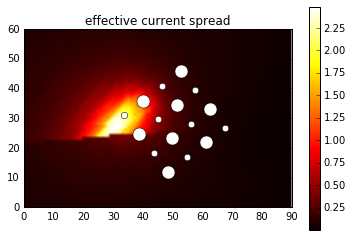

In [8]:
plt.imshow(np.flipud(ecs[..., [idx_E1, idx_E2]].sum(axis=2)), cmap='hot')

# also plot the center points of all the electrodes
# plt.plot(x_elec_loc/r_sampling - x_min/r_sampling, -y_elec_loc/r_sampling - y_min/r_sampling, 'ow')
for x, y, r in zip(x_elec_loc, y_elec_loc, r_arr):
    plt.plot((x - x_min)/r_sampling, (-y - y_min)/r_sampling, 'ow', markersize=r/20)

plt.axis([0, (x_max - x_min) / r_sampling, 0, (y_max - y_min) / r_sampling])
# plt.axis([0, r.gridx.shape[0], 0, r.gridx.shape[1]])
plt.colorbar()
plt.title('effective current spread')
plt.savefig('ecs.eps')

In [9]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(ampl, delay_dur=0, tsample=1e-5):
    from pulse2percept.utils import TimeSeries
    freq = 50
    pulse_dur = 0.45/1000
    stim_dur = 0.5

    # envelope size (single pulse + gap) given by `freq`
    envelope_size = int(np.round((1/freq) / tsample))

    # delay given by `delay_dur`
    delay_size = int(np.round(delay_dur / tsample))
    delay = np.zeros(delay_size)

    # single pulse given by `pulse_dur`
    pulse = ampl * e2cm.get_pulse(pulse_dur, tsample, pulse_dur, 'cathodicfirst')
    pulse_size = pulse.size

    # then gap is used to fill up what's left
    gap_size = envelope_size - delay_size - pulse_size
    gap = np.zeros(gap_size)

    pulse_train = []
    for j in range(int(np.round(stim_dur * freq))):
        pulse_train = np.concatenate((pulse_train, delay, pulse, gap), axis=0)
    
    return TimeSeries(tsample, pulse_train)

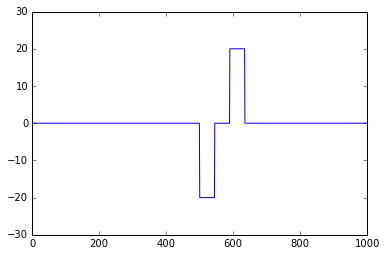

In [10]:
pt = get_pulse_train(20, 0)
plt.plot(pt.data[1500:2500])
plt.ylim(-30, 30)
plt.savefig('pulse.eps')

In [11]:
tm = ec2b.TemporalModel(model='Nanduri', tsample=tsample)
a1 = 30 * 1.25
a2 = 30 * 1.25

pt_list = []
for j in range(16):
    if j == idx_E1:
        pt_list.append(get_pulse_train(a1, tsample=tsample))
    elif j == idx_E2:
        pt_list.append(get_pulse_train(a2, delay_dur=0, tsample=tsample))
    else:
        # all others zero
        pt_list.append(get_pulse_train(0, tsample=tsample))
                    
resp = ec2b.pulse2percept(tm, ecs, retina, pt_list, 30, dojit=True, n_jobs=4)

In [12]:
def get_brightest_frame(resp):
    from pulse2percept.utils import TimeSeries
    # Find brightest element
    idx_px = resp.data.argmax()
    
    # Find frame where brightest pixel is: unravel maps flat index onto
    # high-dimensional indices (x,y,z). What we want is index z (the frame index).
    idx_frame = np.unravel_index(idx_px, resp.shape)[-1]
    
    return TimeSeries(resp.tsample, resp.data[..., idx_frame])

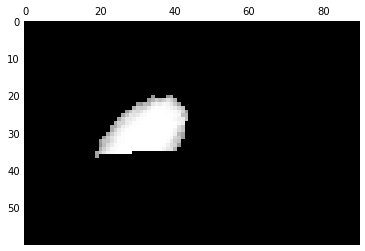

In [13]:
frame = get_brightest_frame(resp)
frame = np.where(frame.data > 30, frame.data, 0)
plt.matshow(frame, cmap='gray', vmin=0)
plt.savefig('percept.eps')

In [14]:
from skimage.filters import gaussian

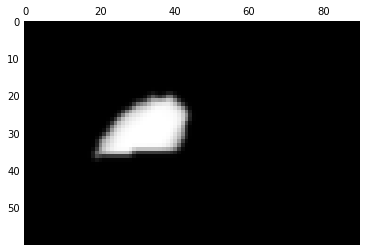

In [15]:
plt.matshow(gaussian(frame, 0.75), cmap='gray', vmin=0)
plt.savefig('percept_smooth.eps')